In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/test.csv')

In [ ]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [ ]:
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [ ]:
columns_to_check = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination' , 'VIP']
for column in columns_to_check:
    unique_values = train_data[column].unique()
    print(f"Unique values in {column}: {unique_values}")

Unique values in HomePlanet: ['Europa' 'Earth' 'Mars' nan]
Unique values in CryoSleep: [False True nan]
Unique values in Cabin: ['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']
Unique values in Destination: ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
Unique values in VIP: [False True nan]


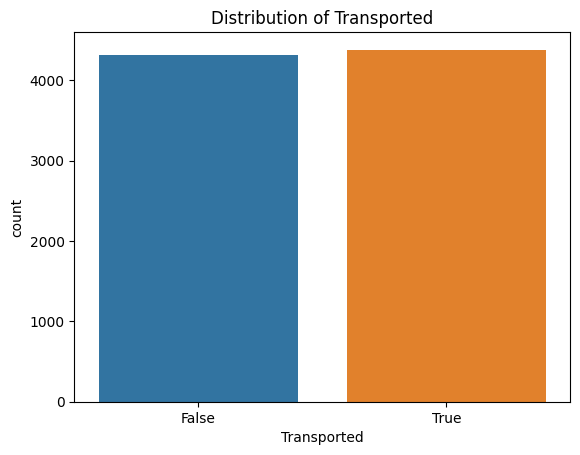

In [ ]:
sns.countplot(x='Transported', data=train_data)
plt.title('Distribution of Transported')
plt.show()

In [ ]:
X_train = train_data.drop(['PassengerId', 'Name', 'Transported'], axis=1)
y_train = train_data['Transported']
X_test = test_data.drop(['PassengerId', 'Name'], axis=1)

In [ ]:
imputer = SimpleImputer(strategy='most_frequent')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Convert categorical features to numeric representations
categorical_cols = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    label_encoders[col].fit(pd.concat([X_train_imputed[col], X_test_imputed[col]]))
    X_train_imputed[col] = label_encoders[col].transform(X_train_imputed[col])
    X_test_imputed[col] = label_encoders[col].transform(X_test_imputed[col])

# One-hot encode categorical variables separately for training and test data
X_train_encoded = pd.get_dummies(X_train_imputed, columns=categorical_cols, prefix=categorical_cols, prefix_sep='_')
X_test_encoded = pd.get_dummies(X_test_imputed, columns=categorical_cols, prefix=categorical_cols, prefix_sep='_')

# Align the features to ensure consistency in column names
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

print(X_train_encoded.shape)
print(X_test_encoded.shape)

(8693, 6576)
(4277, 6576)


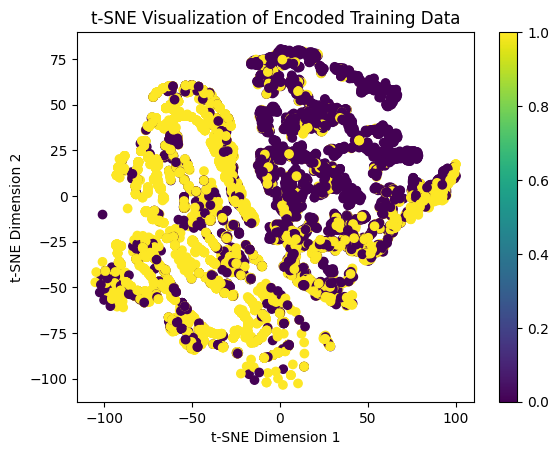

In [ ]:
# Perform train-test split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_encoded, y_train, test_size=0.2, random_state=42)

tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_encoded)

# Visualize t-SNE
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='viridis')
plt.title("t-SNE Visualization of Encoded Training Data")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.colorbar()
plt.show()

In [ ]:
# Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_split, y_train_split)

# Make predictions
y_train_pred = model.predict(X_train_split)
y_val_pred = model.predict(X_val_split)
y_test_pred = model.predict(X_test_encoded)

# Compute accuracy scores
train_accuracy = accuracy_score(y_train_split, y_train_pred)
val_accuracy = accuracy_score(y_val_split, y_val_pred)

print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

# Create prediction dataframes
test_predictions = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Transported': y_test_pred})

#  Save predictions to CSV files
test_predictions.to_csv('test_predictions1.csv', index=False)

Training Accuracy: 0.9992809893586425
Validation Accuracy: 0.7883841288096607


In [ ]:
#Train the model
model = RandomForestClassifier(random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(model, X_train_split, y_train_split, cv=5)

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", np.mean(cv_scores))
print("Standard Deviation of Cross-Validation Scores:", np.std(cv_scores))

# Train the model on the entire training set
model.fit(X_train_split, y_train_split)

#  Make predictions on the test set
y_test_pred = model.predict(X_test_encoded)

test_predictions = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Transported': y_test_pred})

test_predictions.to_csv('test_predictions2.csv', index=False)

Cross-Validation Scores: [0.78648454 0.79079799 0.79151689 0.79583034 0.80071942]
Mean Cross-Validation Score: 0.7930698374442071
Standard Deviation of Cross-Validation Scores: 0.004838916761778038


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_encoded, y_train, test_size=0.2, random_state=42)

#  Train and evaluate KNN classification with different values of k
k_values = [2, 5, 7]  # Example values of k
for k in k_values:
    # Train the model
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_split, y_train_split)

    # Make predictions
    y_train_pred = model.predict(X_train_split)
    y_val_pred = model.predict(X_val_split)

    # Compute accuracy scores
    train_accuracy = accuracy_score(y_train_split, y_train_pred)
    val_accuracy = accuracy_score(y_val_split, y_val_pred)

    print(f"K = {k}:")
    print("Training Accuracy:", train_accuracy)
    print("Validation Accuracy:", val_accuracy)
    print()

#Choose the best k based on validation performance and make predictions with that k
best_k = 7  # Choose the best k based on validation performance

# Train the model with the best k
model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(X_train_encoded, y_train)

# Make predictions on the test data
y_test_pred = model.predict(X_test_encoded)

#  Create prediction dataframe
test_predictions = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Transported': y_test_pred})

# Save predictions to CSV file
test_predictions.to_csv('test_predictions3.csv', index=False)

K = 2:
Training Accuracy: 0.8596491228070176
Validation Accuracy: 0.721679125934445

K = 5:
Training Accuracy: 0.8336209375898763
Validation Accuracy: 0.7688326624496837

K = 7:
Training Accuracy: 0.825711820534944
Validation Accuracy: 0.7809085681426107

